In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import os
import sys
import random
import seaborn as sns
from matplotlib.font_manager import FontProperties
font1 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=14)
font2 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=12)
font3 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=10)
font4 = FontProperties(fname=r"C:\\Windows\\Fonts\\STZHONGS.ttf", size=7)
sns.set_style('whitegrid')
sns.set_palette("muted")
random.seed(20241017)
np.random.seed(20241017)
torch.manual_seed(3407) # Torch.manual_seed(3407) is all you need. Paper: http://arxiv.org/abs/2109.08203
# 修改工作路径，使本.ipynb文件能够像在本文件夹根目录下一样导入其他模块
# Modify the working path so that this.ipynb file can import other modules like in the root directory
current_dir = os.path.dirname(os.path.abspath('__file__'))
sys.path.append(os.path.join(current_dir, '..'))

In [2]:
df_whole=pd.read_excel("E:\\科创优才\\实验数据\\天然气锅炉数据1.xlsx", sheet_name="稳定运行数据段")
units=df_whole.iloc[0].tolist()

In [3]:
df=df_whole.iloc[2:].reset_index(drop=True)
df.columns=new_column_names=[
    '开始时间',
    '主蒸汽流量计算值',
    '烟气含氧量（CEMS）',
    '颗粒浓度',
    '二氧化硫',
    'NO浓度',
    'NO2浓度',
    'NOX标干浓度',
    'NOX浓度',
    '烟气湿度（CEMS）',
    '烟气压力（CEMS）',
    '烟气温度（CEMS）',
    '一氧化碳',
    '锅炉天然气进气流量',
    '锅炉天然气进气温度',
    '锅炉天然气进气压力',
    '鼓风机出口温度',
    '鼓风机出口压力',
    '鼓风机变频器输出反馈',
    '鼓风机变频器电流反馈',
    '再循环烟气调节阀反馈',
    '冷凝器出口烟气调节阀反馈',
    '炉膛出口烟气温度（B分度）',
    '炉膛出口烟气压力',
    'SWY大气压',
    'SWY天气温度',
    'SWY空气湿度',
    'SWY湿球温度',
    '主蒸汽温度(蒸汽集箱出口温度）',
    '主蒸汽压力(蒸汽集箱出口压力）',
    '分汽缸温度',
    '分汽缸压力',
    '分汽缸出口至DN400蒸汽温度',
    '过热器集箱出口蒸汽温度',
    '天然气累计流量',
    '冷凝器烟气流量（累计值）',
    '冷凝器出口烟气流量',
    '冷凝器出口烟气温度'
]

In [23]:
var_names=['主蒸汽流量计算值',
    '烟气含氧量（CEMS）',
    '二氧化硫',
    'NO浓度',
    'NO2浓度',
    'NOX标干浓度',
    'NOX浓度',
    '烟气湿度（CEMS）',
    '烟气压力（CEMS）',
    '烟气温度（CEMS）',
    '一氧化碳',
    '锅炉天然气进气流量',
    '锅炉天然气进气温度',
    '锅炉天然气进气压力',
    '鼓风机出口温度',
    '鼓风机出口压力',
    '鼓风机变频器输出反馈',
    '鼓风机变频器电流反馈',
    '冷凝器出口烟气调节阀反馈',
    '炉膛出口烟气温度（B分度）',
    '炉膛出口烟气压力',
    'SWY大气压',
    'SWY天气温度',
    'SWY空气湿度',
    'SWY湿球温度',
    '主蒸汽温度(蒸汽集箱出口温度）',
    '主蒸汽压力(蒸汽集箱出口压力）',
    '分汽缸温度',
    '分汽缸压力',
    '分汽缸出口至DN400蒸汽温度',
    '过热器集箱出口蒸汽温度',
    '天然气累计流量',
    '冷凝器烟气流量（累计值）',
    '冷凝器出口烟气流量',
    '冷凝器出口烟气温度'
]
data_np=df[var_names].to_numpy(dtype=float)
print(data_np.shape)

(1124, 35)


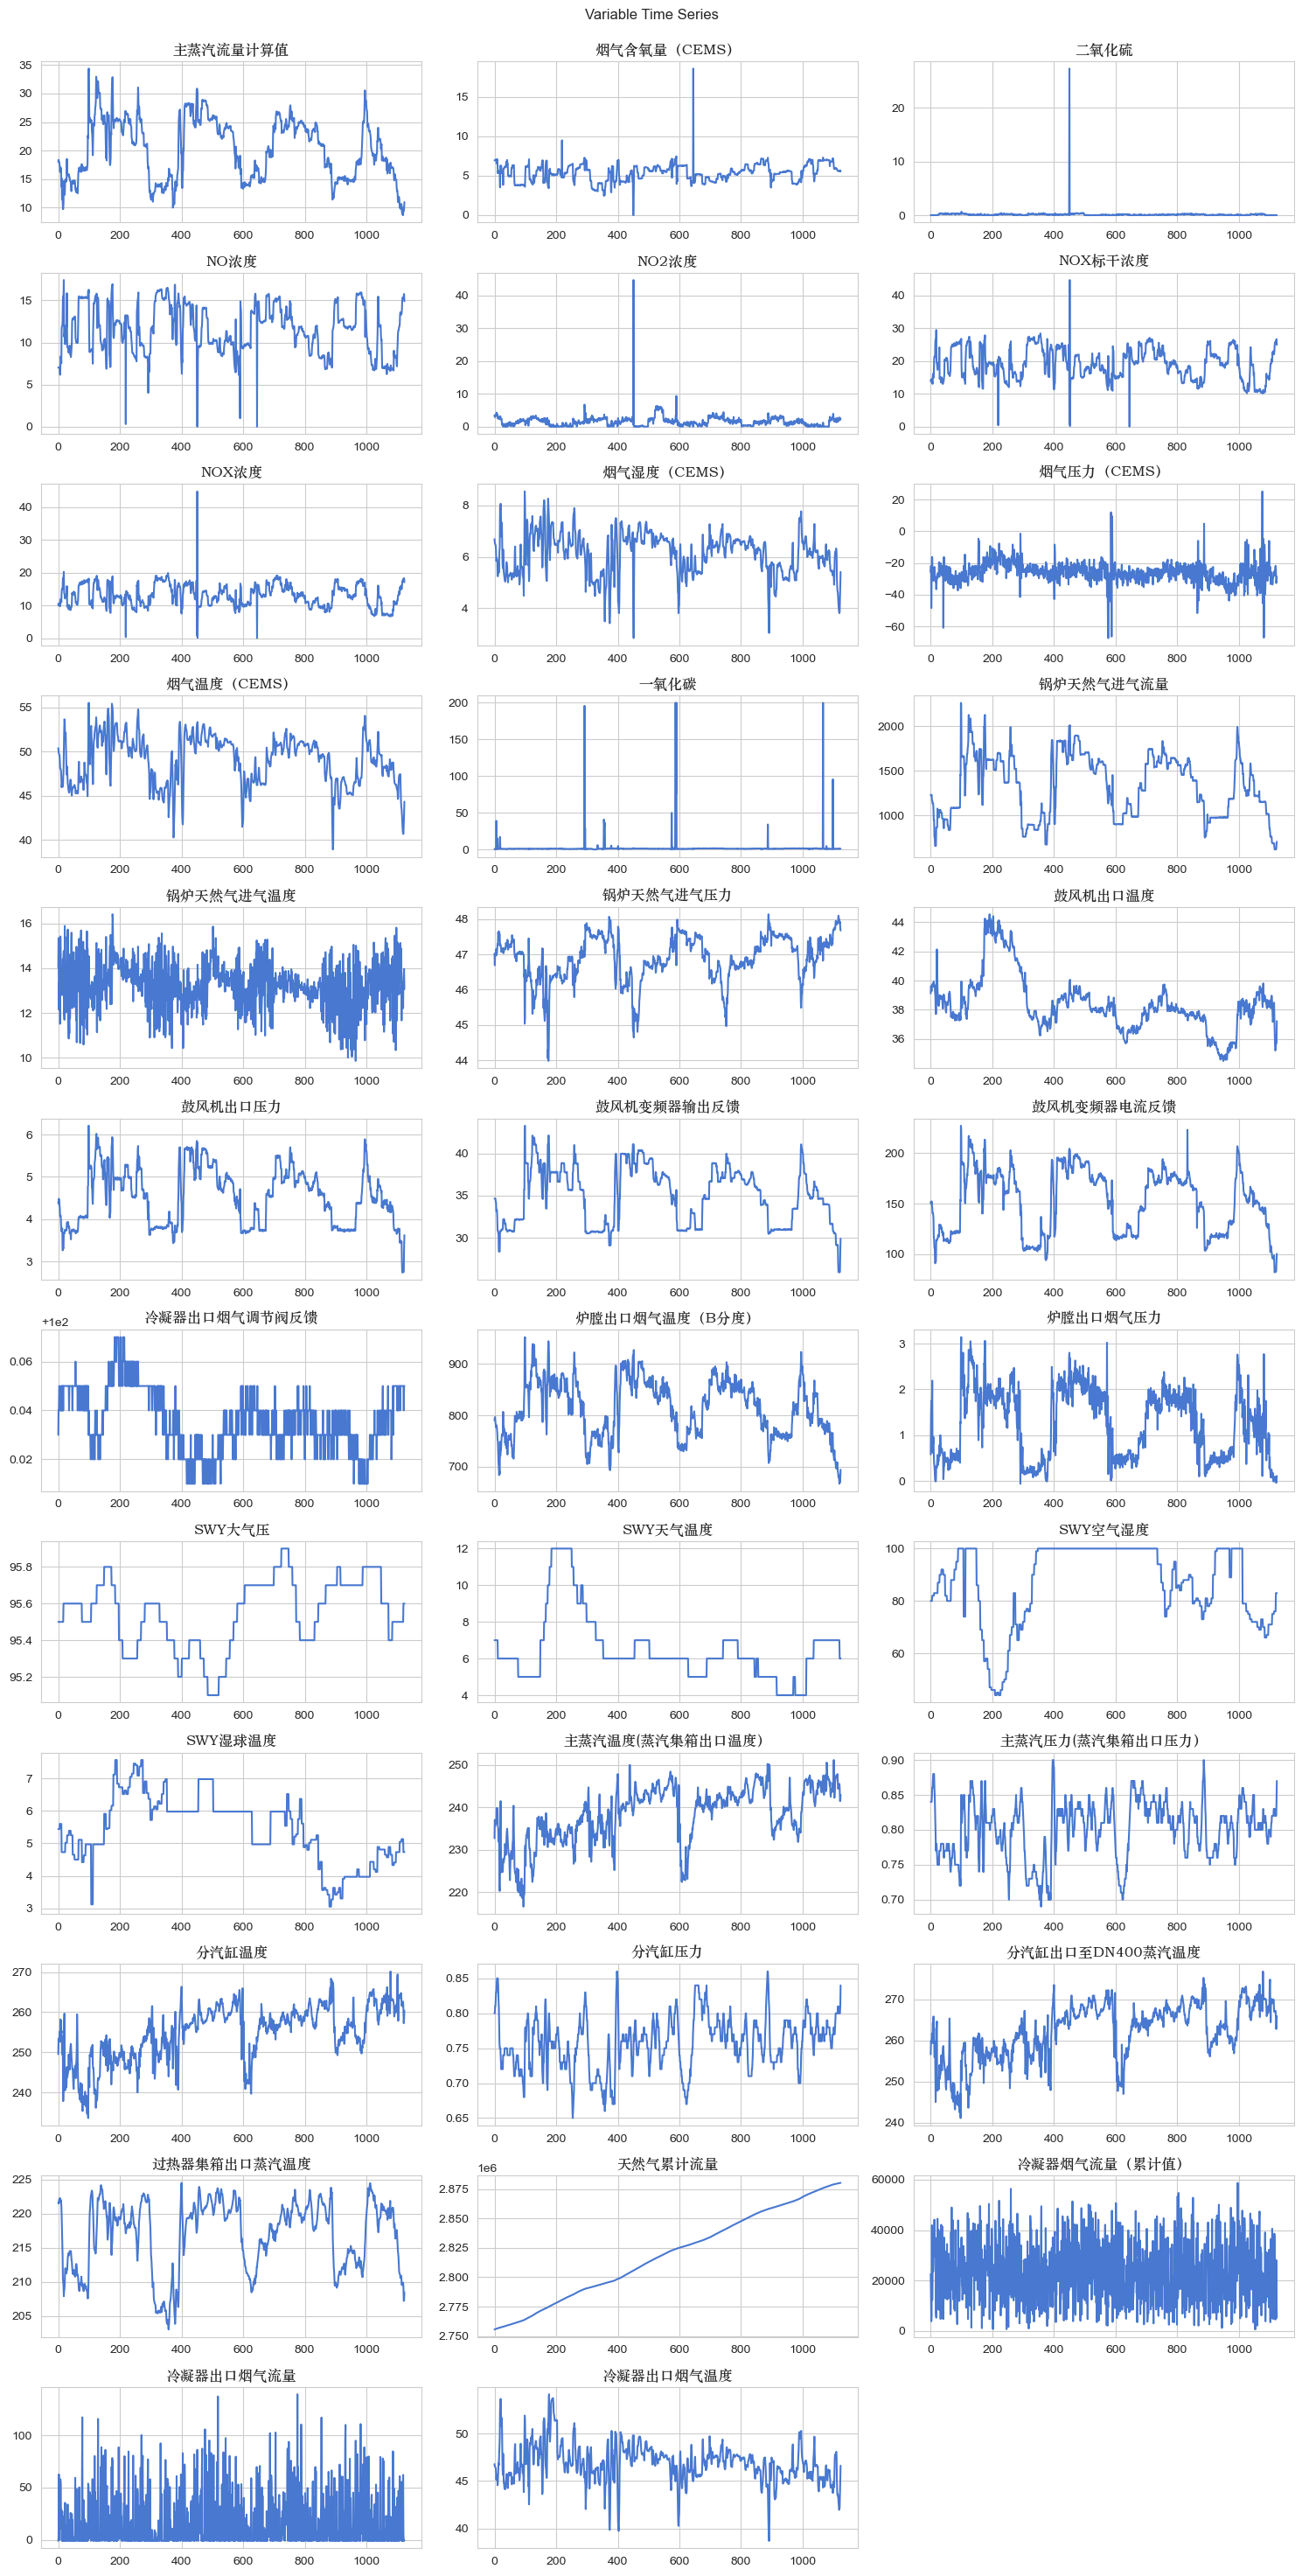

In [24]:
plt.figure(figsize=(15,30))
plt.suptitle('Variable Time Series')
nrows=len(var_names)//3+1
ncolumns=3
length=df.shape[0]
for i, var_name in enumerate(var_names):
    plt.subplot(nrows, ncolumns, i + 1)
    plt.plot(np.arange(length), df[var_name])
    plt.title(var_name, fontproperties=font2)
plt.tight_layout()
plt.subplots_adjust(top=0.96)
plt.show()

In [53]:

def get_XY(data_np,input_len, output_len,
            verbose=1,
            ):
    
    count=0 # 已处理文件数量
    # DATA: list of numpy arrays of shape (mat_data_len, len(var_names))
    '''
    根据采样出的数据库构建用于训练的数据集
    X_grouped: list of(list of (input_length,len(var_names)) numpy array).
                     |<----------input_len------------------->|
    Input sequence:  ├────────────────────────────────────────┤
    Label sequence:                          ├────────────────┤
    Target sequence:                         ├───────────────────────────────────────────────┤
                                             |<--label_len--->|<----------pred_len---------->|
                                             |<-----------------output_len------------------>|
    Time axis------------------------------------------------------------------------------------------->
    '''
    
    time_len=data_np.shape[0]
    var_num=data_np.shape[1]
    X_i=[]
    Y_i=[]
    for i in range(0, time_len-input_len-output_len, output_len):
        X_i.append(data_np[i:i+input_len,:])
        Y_i.append(data_np[i+input_len:i+input_len+output_len,:])
    '''
    Standardization
    '''
    var_sum=np.zeros((var_num))
    var_mean=np.zeros((var_num))
    var_sum2=np.zeros((var_num))
    var_std_dev=np.zeros((var_num))
    count=0 # Total time step length # 总时间长度
    # Calculate average # 计算各变量均值
    for row in data_np:
        var_sum+=row
        count+=1
    var_mean=var_sum/count
    # Calculate variance # 计算各变量方差
    for row in data_np:
        # data: numpy array. Shape: (mat_data_len, len(var_names))
        var_sum2+=(row-var_mean)**2
    var_std_dev=np.sqrt(var_sum2/count)
    
    # Part each time series into subseries with equal shape, in convenience of neural network training.
    X=[]
    Y=[]
    for X_ij in X_i:
        X.append(X_ij)
    for Y_ij in Y_i:
        Y.append(Y_ij)
    X=np.array(X).astype("float32") # X shape: (num_samples, input_len, len(var_names))
    Y=np.array(Y).astype("float32") # Y shape: (num_samples, output_len, len(var_names))

    # Convert data to standardized values # 转化数据
    for i,row in enumerate(X):
        X[i] = (row - var_mean) / var_std_dev

    for i,row in enumerate(Y):
        Y[i] = (row - var_mean) / var_std_dev

    print('X shape: ', X.shape)
    print('Y shape: ', Y.shape)
    return X, Y

X, Y = get_XY(data_np,input_len=8, output_len=1,verbose=1,)

X shape:  (1115, 8, 35)
Y shape:  (1115, 1, 35)


In [54]:
from gas_data_prediction.data_preprocessing import get_XY_loaders

train_loader, val_loader, test_loader = get_XY_loaders(X, Y,batch_size=32,verbose=1)

Train dataset size: X: (780, 8, 35); Y: (780, 1, 35)
Val dataset size: X: (111, 8, 35); Y: (111, 1, 35)
Test dataset size: X: (223, 8, 35); Y: (223, 1, 35)


In [55]:
from models.RNN import RNN, LSTM, GRU
from models.CNN import CNN, TCN
from models.MLP import MLP
from models.transformer import Transformer, iTransformer, PatchTST, Reformer, Informer
from models.Linear import LLinear, DLinear, NLinear
from models.stat import Identical, ExponentialMovingAverage, SVR
from gas_data_prediction.utils import FitHistory

# Hyperparameters
num_epochs = 20
learning_rate = 0.001
input_len = 8
output_len = 1
label_len = 0 # label_len should be set only for decoder-based models, or there is potential risk of data leakage.
input_channels = 35
output_channels = 35
batch_size = 32
#device = 'cpu'  # 设备
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Instantiate models, loss functions, evaluation functions, and optimizers
# 实例化模型、损失函数、评估函数和优化器
MODEL = LSTM(
    input_len=input_len, output_len=output_len, input_channels=input_channels, output_channels=output_channels,
    ).to(device)
loss_func = nn.MSELoss()
metric_func=nn.L1Loss()
optimizer = optim.Adam(MODEL.parameters(), lr=learning_rate)
history=FitHistory()
print('Model parameters: ', sum(p.numel() for p in MODEL.parameters()))

Model parameters:  12259


 10%|█         | 2/20 [00:00<00:02,  7.69it/s]

Epoch [ 1  /20], Time: 0.1422s, Loss: 0.9678, Metric: 0.7672, Val Loss: 1.1759, Val Metric: 0.7609
Epoch [ 2  /20], Time: 0.1205s, Loss: 0.8378, Metric: 0.6914, Val Loss: 0.9495, Val Metric: 0.6022


 25%|██▌       | 5/20 [00:00<00:01,  9.10it/s]

Epoch [ 3  /20], Time: 0.1028s, Loss: 0.7202, Metric: 0.6110, Val Loss: 1.0939, Val Metric: 0.5892
Epoch [ 4  /20], Time: 0.0988s, Loss: 0.6543, Metric: 0.5725, Val Loss: 0.7893, Val Metric: 0.5345
Epoch [ 5  /20], Time: 0.1066s, Loss: 0.5926, Metric: 0.5392, Val Loss: 0.9437, Val Metric: 0.5295


 35%|███▌      | 7/20 [00:00<00:01,  9.71it/s]

Epoch [ 6  /20], Time: 0.0978s, Loss: 0.5588, Metric: 0.5205, Val Loss: 0.7685, Val Metric: 0.5042
Epoch [ 7  /20], Time: 0.0936s, Loss: 0.5301, Metric: 0.5041, Val Loss: 0.6834, Val Metric: 0.4764
Epoch [ 8  /20], Time: 0.0981s, Loss: 0.4929, Metric: 0.4769, Val Loss: 0.7177, Val Metric: 0.4640


 50%|█████     | 10/20 [00:01<00:01,  9.82it/s]

Epoch [ 9  /20], Time: 0.0960s, Loss: 0.4631, Metric: 0.4559, Val Loss: 0.6278, Val Metric: 0.4450
Epoch [ 10 /20], Time: 0.1042s, Loss: 0.4328, Metric: 0.4353, Val Loss: 0.5987, Val Metric: 0.4273


 60%|██████    | 12/20 [00:01<00:00,  9.53it/s]

Epoch [ 11 /20], Time: 0.1049s, Loss: 0.4071, Metric: 0.4182, Val Loss: 0.5812, Val Metric: 0.4125
Epoch [ 12 /20], Time: 0.1088s, Loss: 0.3922, Metric: 0.4080, Val Loss: 0.5732, Val Metric: 0.4094


 75%|███████▌  | 15/20 [00:01<00:00,  9.75it/s]

Epoch [ 13 /20], Time: 0.1063s, Loss: 0.4030, Metric: 0.3983, Val Loss: 0.5657, Val Metric: 0.4030
Epoch [ 14 /20], Time: 0.0994s, Loss: 0.3638, Metric: 0.3856, Val Loss: 0.5670, Val Metric: 0.3960
Epoch [ 15 /20], Time: 0.0985s, Loss: 0.3522, Metric: 0.3738, Val Loss: 0.5615, Val Metric: 0.3842


 85%|████████▌ | 17/20 [00:01<00:00,  9.91it/s]

Epoch [ 16 /20], Time: 0.0968s, Loss: 0.3431, Metric: 0.3653, Val Loss: 0.7536, Val Metric: 0.3996
Epoch [ 17 /20], Time: 0.1001s, Loss: 0.3351, Metric: 0.3589, Val Loss: 0.5550, Val Metric: 0.3782


 90%|█████████ | 18/20 [00:01<00:00,  9.86it/s]

Epoch [ 18 /20], Time: 0.1021s, Loss: 0.3286, Metric: 0.3530, Val Loss: 0.5389, Val Metric: 0.3720
Epoch [ 19 /20], Time: 0.0967s, Loss: 0.3237, Metric: 0.3494, Val Loss: 0.5903, Val Metric: 0.3717


100%|██████████| 20/20 [00:02<00:00,  9.61it/s]

Epoch [ 20 /20], Time: 0.0947s, Loss: 0.3155, Metric: 0.3421, Val Loss: 0.5354, Val Metric: 0.3631
Total Time: 2.0688s


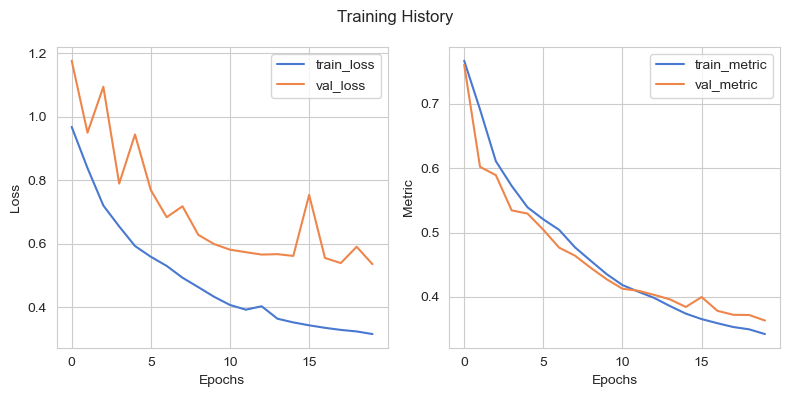

Number of epochs:  20
Training time:     2.0688s
Training loss:     0.3155
Training metric:   0.3421
Validation loss:   0.5354
Validation metric: 0.3631


100%|██████████| 7/7 [00:00<00:00, 882.24it/s]

Loss on test set:  0.3298597660567194


In [56]:
from gas_data_prediction.utils import train, plot_predictions
# train the model
history.update(
            *train(MODEL, train_loader, val_loader, optimizer,
                loss_func=nn.MSELoss(),
                metric_func=nn.L1Loss(),
                num_epochs=num_epochs,
                device=device,
                verbose=1)
            )
history.plot()
history.summary()
print("Loss on test set: ", MODEL.evaluate(test_loader,device=device))

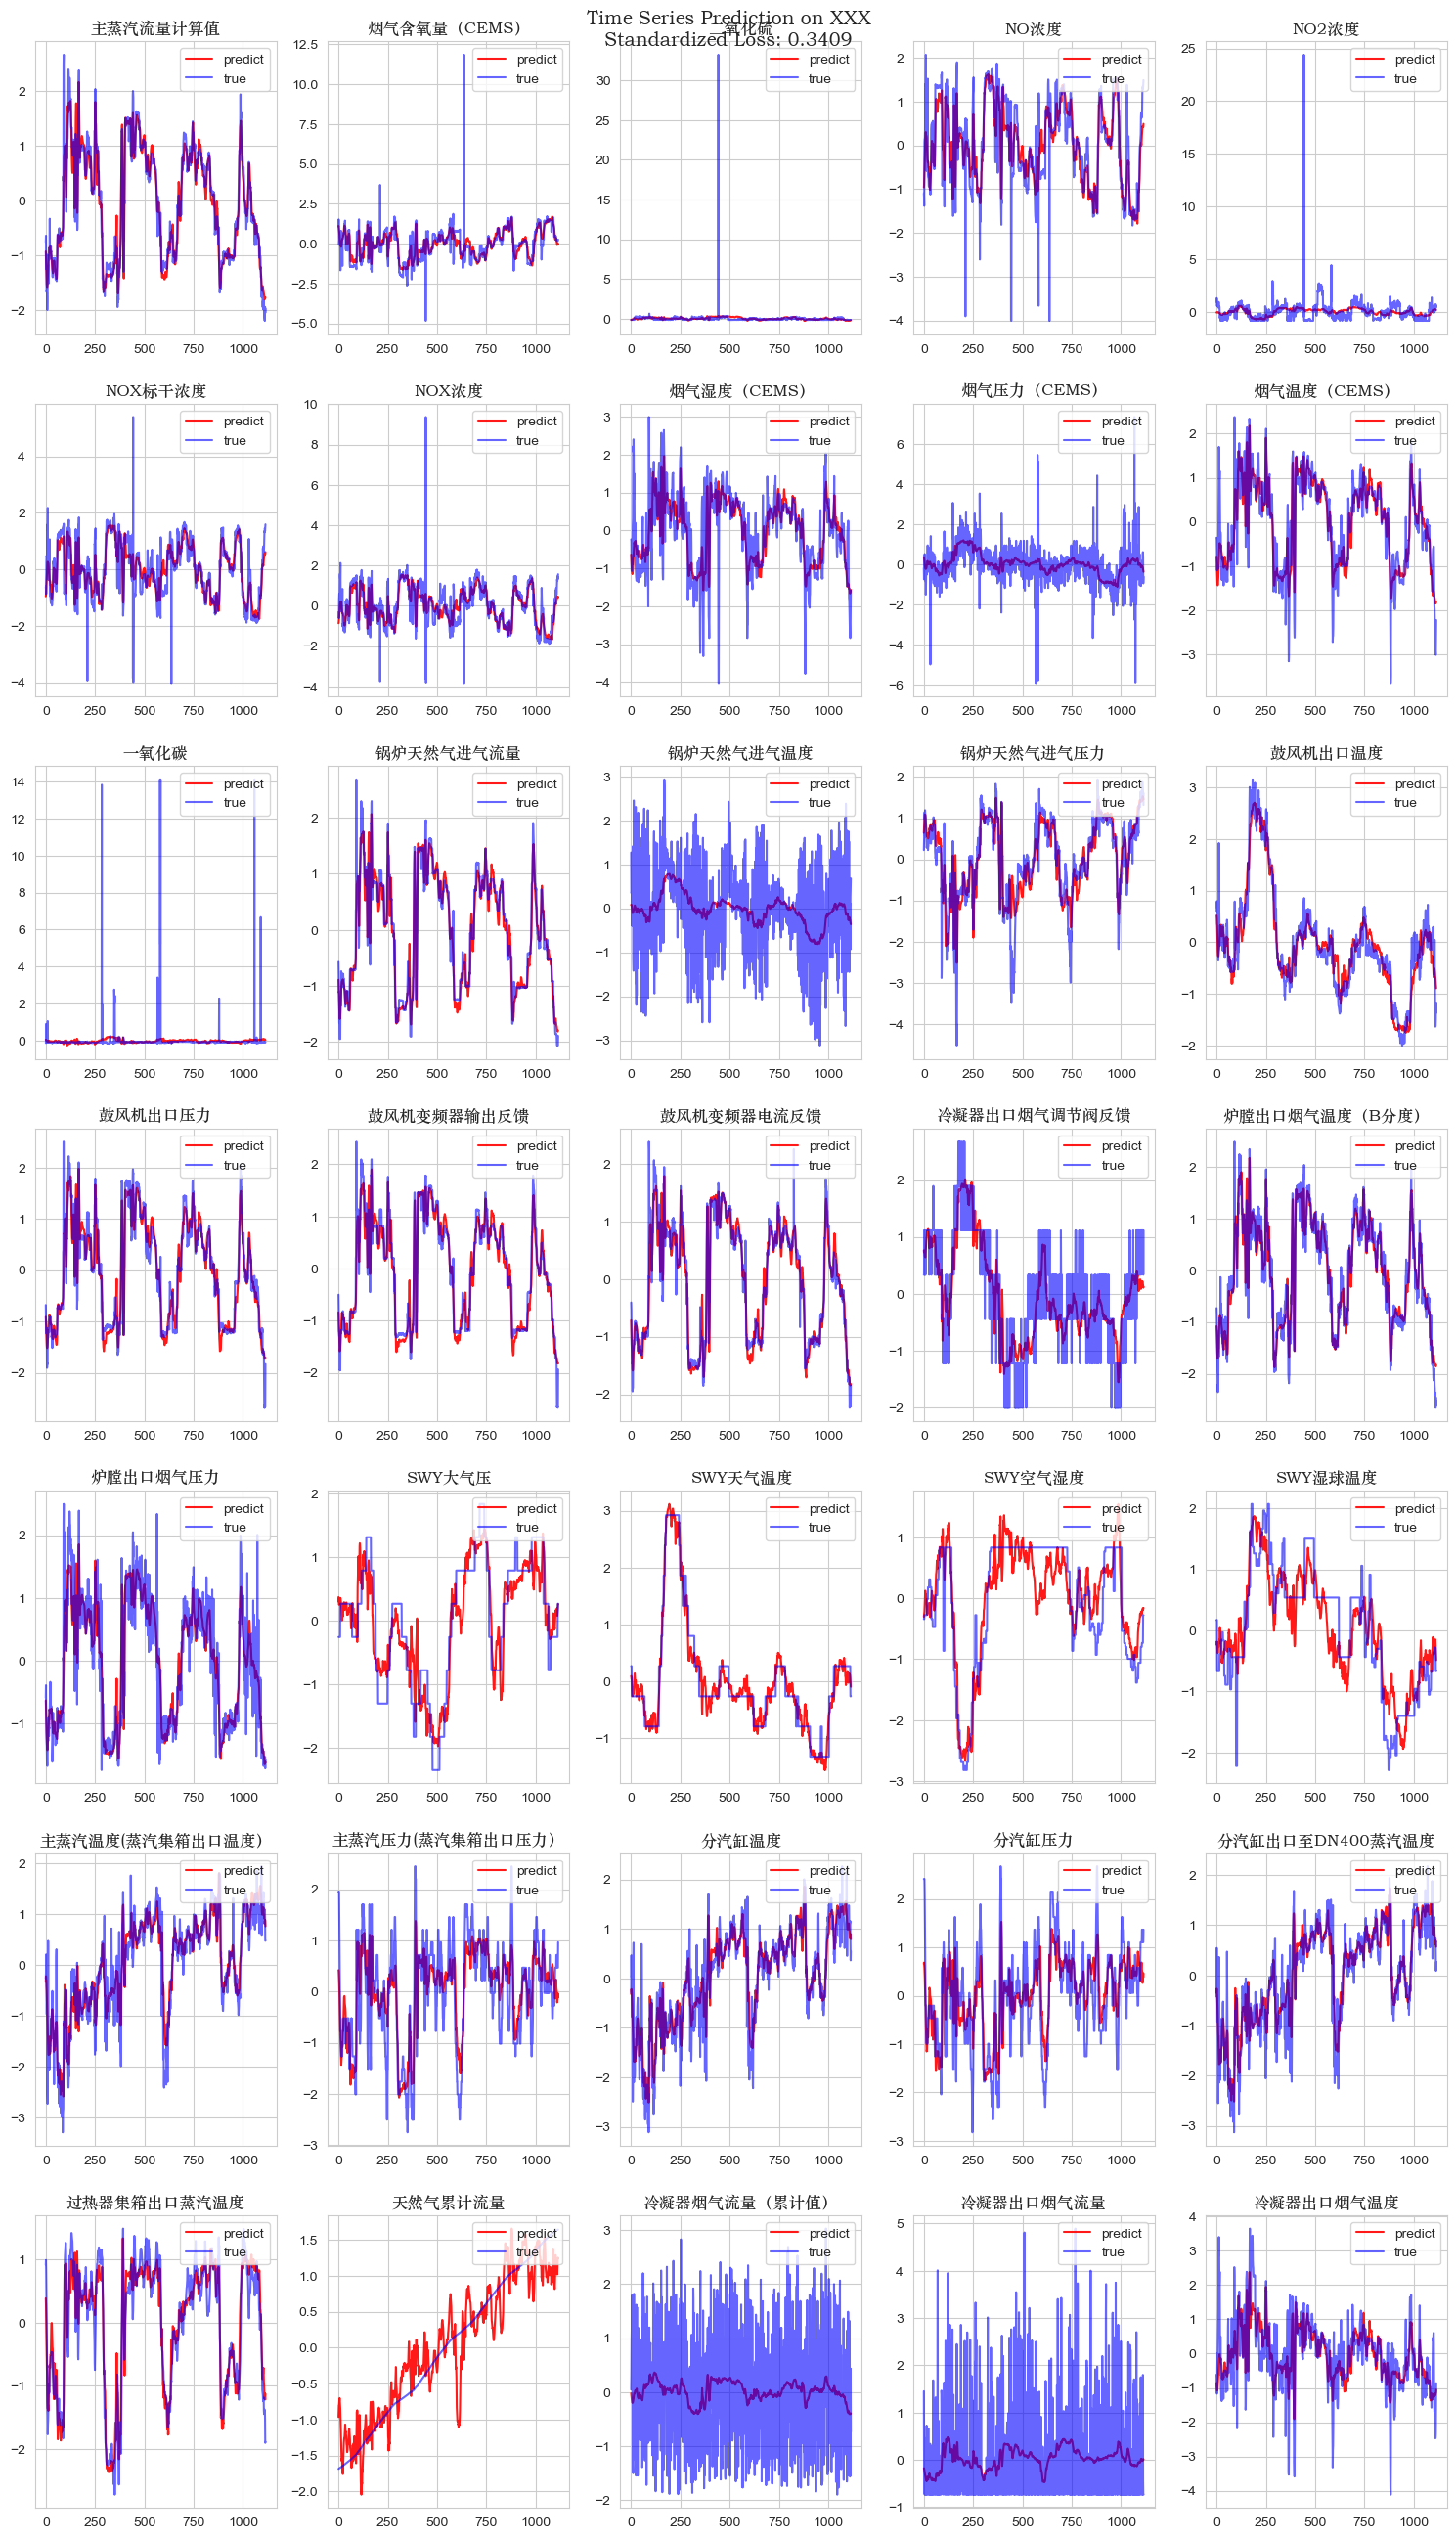

In [57]:
X_to_predict=X # 作为输入的真实数据
Y_to_predict=Y # 待预测的真实数据

Y_predicted=MODEL(torch.Tensor(X_to_predict).to(device)).cpu().detach().numpy() # 根据X_to_predict预测到的数据
output_channels=Y_predicted.shape[2]
Y_predicted_flatten=Y_predicted.reshape(-1,output_channels)
Y_to_predict_flatten=Y_to_predict.reshape(-1,output_channels)
loss=np.mean((Y_predicted_flatten-Y_to_predict_flatten)**2) # 计算预测误差

plt.figure(figsize=(15,30)) # figsize is specified in the function parameter
import os
plt.suptitle('Time Series Prediction on {}\nStandardized Loss: {:.4f}'.format(
            'XXX', loss),
            fontproperties=font1)
for var_name in var_names:
    var_idx=var_names.index(var_name)
    plt.subplot(8, 5, var_idx+1)
    plt.plot(Y_predicted_flatten[:,var_idx], alpha=0.9, c='red')
    plt.plot(Y_to_predict_flatten[:,var_idx], alpha=0.6, c='blue')
    plt.legend(['predict', 'true'], loc='upper right')
    plt.title(var_name, fontproperties=font2)
plt.tight_layout(h_pad=2)
#plt.savefig("", bbox_inches='tight')
plt.show()

In [61]:
y_train.shape

(892,)